We use packages Images.jl and TestImages.jl

In [1]:
using Images, TestImages

Define the total variation operator for each index.

In [2]:
function nabla(x)
    G=zeros(size(x,1),size(x,2),2);
    G[1:size(x,1),1:size(x,2)-1,1]-=x[1:size(x,1),1:size(x,2)-1]
    G[1:size(x,1),1:size(x,2)-1,1]+=x[1:size(x,1),2:size(x,2)]
    G[1:size(x,1)-1,1:size(x,2),2]-=x[1:size(x,1)-1,1:size(x,2)]
    G[1:size(x,1)-1,1:size(x,2),2]+=x[2:size(x,1),1:size(x,2)]
    return G
end

nabla (generic function with 1 method)

Define the inversion of previous function

In [3]:
function nablaT(G)
    x=zeros(size(G,1),size(G,2))
    x[1:size(x,1),1:size(x,2)-1]-=G[1:size(x,1),1:size(x,2)-1,1]
    x[1:size(x,1),2:size(x,2)]+=G[1:size(x,1),1:size(x,2)-1,1]
    x[1:size(x,1)-1,1:size(x,2)]-=G[1:size(x,1)-1,1:size(x,2),2]
    x[2:size(x,1),1:size(x,2)]+=G[1:size(x,1)-1,1:size(x,2),2]
    return x
end

nablaT (generic function with 1 method)

Define a norm operator for later usage

In [4]:
function anorm(A)
    C=A.*A
    return sqrt.(C[:,:,1]+C[:,:,2])
end

anorm (generic function with 1 method)

Define a function for energy calculation

In [5]:
function calc_energy_ROF(X, observation, clambda)
    Ereg=0.
    a = anorm(nabla(X))
    for i in a
        Ereg+=i
    end
    Edata=0.;
    for i=1:size(X,1)
        for j=1:size(X,2)
            Edata=Edata+abs((X[i,j]-observation[i,j])^2)
        end
    end
    Edata=Edata*clambda
    return Ereg + Edata
end

calc_energy_ROF (generic function with 1 method)

Define the projection

In [6]:
function project_nd(P, r)
    nP = max.(1.0, anorm(P)/r)
    return P ./ nP
end

project_nd (generic function with 1 method)

Solving the total variation problem using the previous functions.

In [7]:
function solve_ROF(img, clambda, iter_n=101)
    # setting step sizes and other params
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

    X = copy(img)
    P = nabla(X)
    for i in 1:iter_n
        P = project_nd( P .+ sigma.*nabla(X), 1.0 )
        lt = clambda * tau
        X1 = (X - tau * nablaT(P) + lt * img) / (1.0 + lt)
        X = X1 .+ theta * (X1 - X)
        if i % 10 == 0
            print(calc_energy_ROF(X, img, clambda),"  ");
        end
    end
    return X
end

solve_ROF (generic function with 2 methods)

Use the test image lena from TestImages,jl

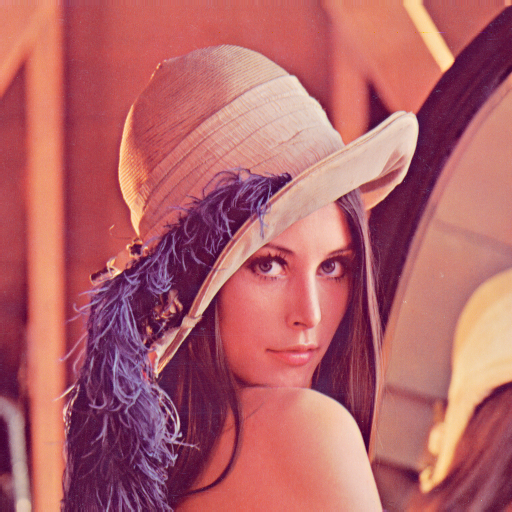

In [8]:
img = testimage("lena_color_512")

Construct a pepper and salt noise

In [9]:
B=zeros(size(img,1),size(img,2))
for i=1:size(img,1)
    for j=1:size(img,2)
        if rand() >=0.8
            B[i,j] = 0
        elseif rand() <= 0.2
            B[i,j]=1
        else
            B[i,j]=3
        end
    end
end

Construct the Gaussian noise

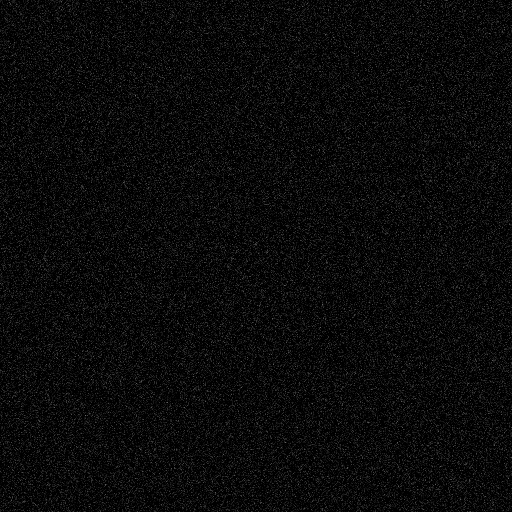

In [32]:
C=Gray.(sqrt(0.01)*(randn(size(img,1),size(img,2))))

Apply the pepper and salt noise

In [11]:
chimg=copy(channelview(img));
for k=1:3
    for i=1:size(img,1)
        for j=1:size(img,2)
            if B[i,j]==0
                chimg[k,i,j]=B[i,j];
            end
            if B[i,j]==1
                chimg[k,i,j]=B[i,j];
            end
        end
    end
end

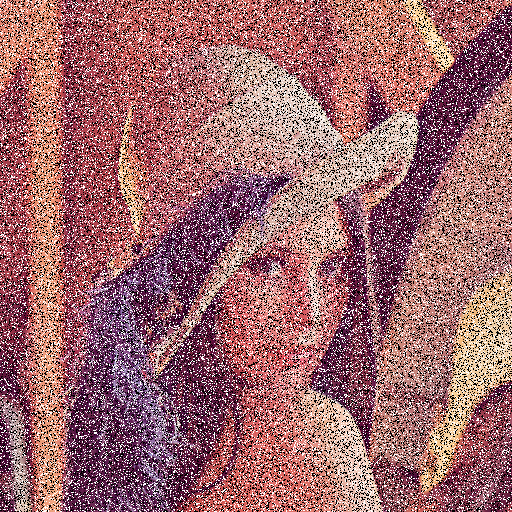

In [12]:
img2 = colorview(RGB,chimg)

Apply the gaussian noise

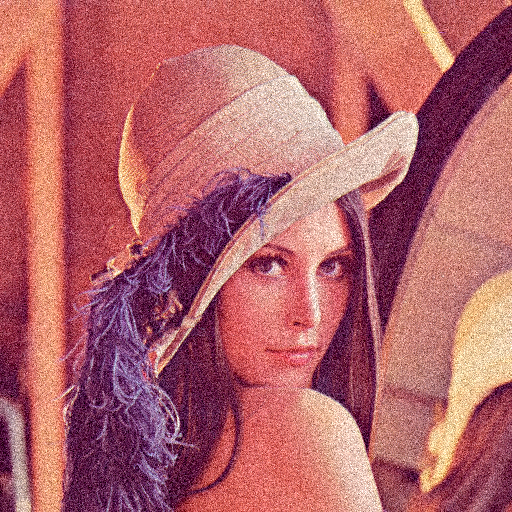

In [13]:
img3 = img.+C

Seperate the first corrupted image to three colors spaces, then solve them

In [14]:
chimg2=channelview(img2);

In [25]:
@time T1=solve_ROF(chimg2[1,:,:],2,101);

68330.90008818383  65717.57482851042  63683.725247167364  62499.351293973275  61749.56715524984  61290.079995843196  60998.70609461787  60813.30458146166  60695.34042483021  60620.72526194511    3.186060 seconds (11.05 k allocations: 9.667 GiB, 47.34% gc time)


In [26]:
@time T2=solve_ROF(chimg2[2,:,:],2,101);

62311.340519159756  59113.86865469843  56953.34412635277  55739.71744197946  54994.55440946055  54523.75998367862  54229.59467354572  54048.168262601255  53931.81386903225  53861.392691111214    3.151413 seconds (11.05 k allocations: 9.667 GiB, 47.47% gc time)


In [27]:
@time T3=solve_ROF(chimg2[3,:,:],2,101);

59335.04599908371  55969.76955127126  53604.645035621594  52281.218885496666  51452.13563594023  50930.651727930825  50597.85022297789  50391.77227870549  50259.532244079164  50176.40150071663    3.221592 seconds (11.05 k allocations: 9.667 GiB, 48.71% gc time)


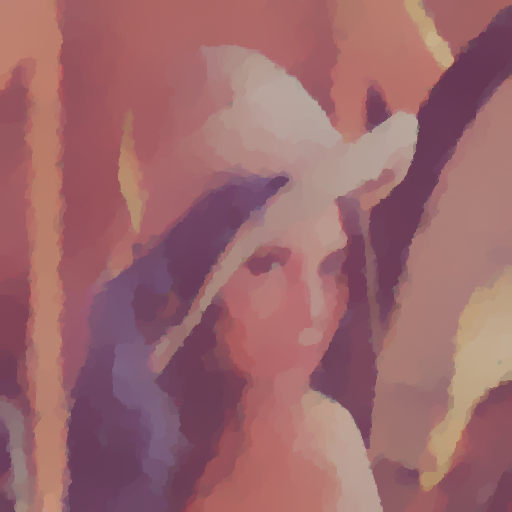

In [18]:
imgT=zeros(3,size(img,1),size(img,2));
imgT[1,:,:]=T1;
imgT[2,:,:]=T2;
imgT[3,:,:]=T3;
imgTc=colorview(RGB,imgT)

Seperate the second corrupted image to three colors spaces, then solve them

In [19]:
chimg3=channelview(img3);

In [28]:
@time S1=solve_ROF(chimg3[1,:,:],2,101);

21067.489220116142  15804.629293146125  12928.546045992967  11235.232219776  10142.799214843173  9435.601567540029  8980.43908020759  8692.53836877203  8507.659987745295  8391.187380937432    3.163526 seconds (11.05 k allocations: 9.684 GiB, 47.47% gc time)


In [29]:
@time S2=solve_ROF(chimg3[2,:,:],2,101);

21433.896030393524  16228.324071830291  13455.862291775928  11862.93257862206  10844.336175803197  10207.408832449684  9810.941027591036  9559.943145488156  9401.527080164691  9302.77126613706    3.182970 seconds (11.05 k allocations: 9.684 GiB, 47.33% gc time)


In [30]:
@time S3=solve_ROF(chimg3[3,:,:],2,101);

21284.97031348555  15782.214865700518  12767.08383101114  10991.438688778862  9847.121842693194  9123.480932018327  8672.138523568685  8380.461458074695  8199.231528449498  8083.708013596388    3.244941 seconds (11.05 k allocations: 9.684 GiB, 48.58% gc time)


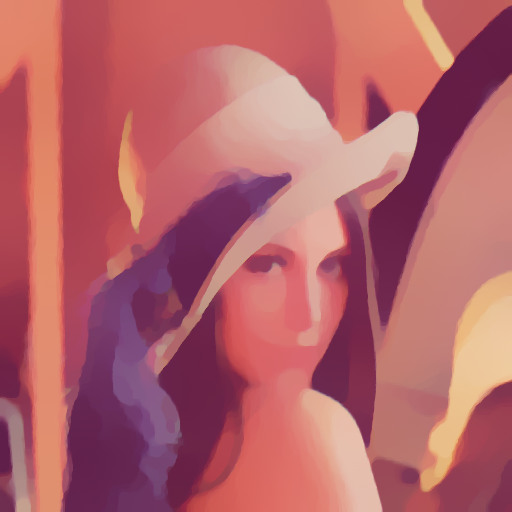

In [23]:
imgS=zeros(3,size(img,1),size(img,2));
imgS[1,:,:]=S1;
imgS[2,:,:]=S2;
imgS[3,:,:]=S3;
imgSc=colorview(RGB,imgS)

In [24]:
save("img.png",img);save("img2.png",img2);save("img3.png",img3);save("imgSc.png",imgSc);save("imgTc.png",imgTc);

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick /home/misc/.julia/packages/ImageMagick/AdMiw/src/ImageMagick.jl:167
